**Содержание:**

1. Задание
2. Импорт библиотек и дополнительные функции
3. Оценка стоимости квартир.

   3.1 Функции парсинга

   3.2 Загрузить xTrain на числовых данных.

   3.3 Загрузить xTrainС из Примечаний (тексты).

   3.4 Создать словарь.

   3.4 Превратить xTrainC в формат bag of words (2000 самых популярных слов).

   3.5 Сделать нормирование данных.

   3.6 Написать нейронную сеть.

      - 3.6.1 Нейронная сеть на простых числовых данных - xTrain

      - 3.6.2 Нейронная сеть на простых текстовых данных - xTrainС

      - 3.6.3 Составная нейронная сеть числовые и тектовые данные
    
4. Общая таблица

5. Выводы

# 1. Задание

Задание **Lite**

Используя шаблон ноутбука, используйте базу квартир чтобы осуществить следующее следующее:

- Загрузить xTrain на числовых данных.

- Загрузить xTrainС из Примечаний (тексты).

- Создать словарь.

- Превратить xTrainC в формат bag of words (2000 самых популярных слов).

- Сделать нормирование данных.

- Написать нейронную сеть.

# 2. Импорт библиотек и дополнительные функции

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
from google.colab import drive
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import random
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Подключаем гугл диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Дополнительные функции: вывода summary и схемы нейронной сети, графика обучения, сохранение истории обучения

In [ ]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  #model.summary()
  print ("\n\n")
  return plot_model(model, dpi=80, show_shapes=True)

In [ ]:
# Функция вывода графиков
def chart(hist):
  plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя абсолютная ошибка')
  plt.legend()
  plt.show()

In [ ]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []  
  # В цикле проходимся по всем значениям из history                                                  
  for i in hist.history.values():                                        
    dct.append(i)                                            # Результат выгружаются в словарь.                                                                
  result = np.array(dct)                                     # Переводим в numpy массив. 
  return result

In [ ]:
# Создадим таблицу [Значения maxWordsCount, Число нейроново в слое Dense, Значение в слое Dropout, Активационная функция в первом слое Dense, Кол-во эпох, размер batch_size, Ошибки, Точность ]
df_result = pd.DataFrame(columns = ['loss', 'mae', 'val_loss', 'val_mae'])

# 3. Оценка стоимости квартир

In [ ]:
# Загрузим данные в data frame
df = pd.read_csv('/content/drive/MyDrive/Регрессия база/База квартир/moscow.csv', sep = ';')


In [ ]:
df.head(2)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Выбираем только нечетные строки
df = df.iloc[::2,:]
# Записываем данные в numpy
data = df.values

In [ ]:
df.head(2)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...


In [ ]:
# Посмотрим имена колонок
print(df.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


## 3.1 Функции парсинга

In [ ]:
# Максимальное число комнат
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0]  # Получаем число комнат
  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr)
    if (roomsCount > maxRoomCount):
      roomsCount = maxRoomCount
  except: 
    if roomsCountStr == roomsCountStr:  # Проверка на NaN
      if ('Ст' in roomsCountStr):
        roomsCount = maxRoomCount + 1
  return roomsCount

In [ ]:
# Число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount)  # Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount + 2 )  # Превращаем в категорию
  return roomsCount

In [ ]:
# Индекс станции метро
def getMetro(d, allMetroNames):
  metroStr = d[1]
  metro = 0

  if metroStr in allMetroNames:
    metro = allMetroNames.index(metroStr) + 1
  return metro

In [ ]:
# Тип метро
def getMetroType(d):
  metroTypeStr = d[1]
  metroTypeClasses = 5 # Число классов
  metroType = metroTypeClasses - 1  # Изначально последний класс

  # Внутри кольца
  metroNamesInsideCircle = ["Площадь Революции м.", "Арбатская м.", "Смоленская м.", "Красные Ворота м.", "Чистые пруды м.", "Лубянка м.", "Охотный Ряд м.", "Библиотека имени Ленина м.", "Кропоткинская м.", "Сухаревская м.", "Тургеневская м.", "Китай-город м.", "Третьяковская м.", "Трубная м.", "Сретенский бульвар м.", "Цветной бульвар м.", "Чеховская м.", "Боровицкая м.", "Полянка м.", "Маяковская м.", "Тверская м.", "Театральная м.", "Новокузнецкая м.", "Пушкинская м.", "Кузнецкий Мост м.", "Китай-город м.", "Александровский сад м."]
  # На кольце
  metroNamesCircle = ["Киевская м.", "Парк Культуры м.", "Октябрьская м.", "Добрынинская м.", "Павелецкая м.", "Таганская м.", "Курская м.", "Комсомольская м.", "Проспект Мира м.", "Новослободская м.", "Белорусская м.", "Краснопресненская м."]
  # 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская м.", "Электрозаводская м.", "Семёновская м.", "Площадь Ильича м.", "Авиамоторная м.", "Шоссе Энтузиастов м.", "Шелепиха м.", "Римская м.", "Крестьянская Застава м.", "Дубровка м.", "Пролетарская м.", "Волгоградский проспект м.", "Текстильщики м.", "Автозаводская м.", "Технопарк м.", "Коломенская м.", "Тульская м.", "Нагатинская м.", "Нагорная м.", "Шаболовская м.", "Ленинский проспект м.", "Академическая м.", "Фрунзенская м.", "Спортивная м.", "Воробьёвы горы м.", "Студенческая м.", "Кутузовская м.", "Фили м.", "Парк Победы м.", "Выставочная м.", "Международная", "Улица 1905 года м.", "Беговая м.", "Полежаевская м.", "Динамо м.", "Аэропорт м.", "Сокол м.", "Деловой центр м.", "Шелепиха м.", "Хорошёвская м.", "ЦСКА м.", "Петровский парк м.", "Савёловская м.", "Дмитровская м.", "Тимирязевская м.", "Достоевская м.", "Марьина Роща м.", "Бутырская м.", "Фонвизинская м.", "Рижская м.", "Алексеевская м.", "ВДНХ м.", "Красносельская м.", "Сокольники м.", "Преображенская площадь м."]
  # 4-8 станций от кольца
  metroNames48FromCircle = ["Партизанская м.", "Измайловская м.", "Первомайская м.", "Планерная м.", "Щёлковская м.", "Пятницкое шоссе м.", "Новокосино м.", "Новогиреево м.", "Перово м.", "Кузьминки м.", "Рязанский проспект м.", "Выхино м.", "Лермонтовский проспект м.", "Жулебино м.", "Партизанская м.", "Измайловская м.", "Первомайская м.", "Щёлковская м.", "Новокосино м.", "Новогиреево м.", "Перово м.", "Кузьминки м.", "Рязанский проспект м.", "Выхино м.", "Лермонтовский проспект м.", "Жулебино м.", "Улица Дмитриевского м.", "Кожуховская м.", "Печатники м.", "Волжская м.", "Люблино м.", "Братиславская м.", "Коломенская м.", "Каширская м.", "Кантемировская м.", "Царицыно м.", "Орехово м.", "Севастопольская м.", "Чертановская м.", "Южная м.", "Пражская м.", "Варшавская м.", "Профсоюзная м.", "Новые Черёмушки м.", "Калужская м.", "Беляево м.", "Коньково м.", "Университет м.", "Багратионовская м.", "Филёвский парк м.", "Пионерская м.", "Кунцевская м.", "Молодёжная м.", "Октябрьское Поле м.", "Щукинская м.", "Спартак м.", "Тушинская м.", "Сходненская м.", "Войковская м.", "Водный стадион м.", "Речной вокзал м.", "Беломорская м.", "Ховрино м.", "Петровско-Разумовская м.", "Владыкино м.", "Отрадное м.", "Бибирево м.", "Алтуфьево м.", "Фонвизинская м.", "Окружная м.", "Верхние Лихоборы м.", "Селигерская м.", "ВДНХ м.", "Ботанический сад м.", "Свиблово м.", "Бабушкинская м.", "Медведково м.", "Преображенская площадь м.", "Черкизовская м.", "Бульвар Рокоссовского м."]

  # Корректируем категорию 
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  # Превращаем в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType

In [ ]:
# Расстояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0     #Расстояние
  metroDistanceType = 0 #Тип пешком или на транспорте
  
  if (metroDistanceStr == metroDistanceStr):  # Проверка что не NaN
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1              # Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2              # На транспорте

      metroDistanceStr = metroDistanceStr[:-1]  # Делаем только число
      try:
        #Разделяем на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: # Если в строке не число, то категория 0
        metroDistance = 0
  
  metroDistanceClasses = 7
  
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses 
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses 
    
  # В категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

In [ ]:
# Этаж, этажность, индикатор последнего этажа, тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ""
  
  houseType = 0   #Тип 
  floor = 0       #Этаж квартиры
  floors = 0      #Этажность
  isLastFloor = 0 #Индикатор последнего этажа
  
  if (houseStr == houseStr): # Проверяем на nan
    if (len(houseStr) > 1):
      try:
        slashIndex = houseStr.index("/") 
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") 
      except:
        print(houseStr)

      # Вытаскиваем строки
      floorStr = houseStr[:slashIndex]              # Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] # Строка этажности дома
      houseTypeStr = houseStr[spaceIndex+1:]        # Строка типа дома
      print('Строка этажа floorStr', floorStr)
      print('Строка этажности дома floorsStr', floorsStr)
      print('Строка типа дома houseTypeStr', houseTypeStr)

      # Выбираем категорию этажа
      try:
        floor = int(floorStr) # В число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        elif (floorSave < 10):
          floor = 3
        elif (floorSave < 20):
          floor = 4
        elif (floorSave >= 20):
          floor = 5
        if (floorSave == 1): # Первый этаж в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): # Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0  # (отдельная)
      print(' категорию этажа floor', floor)

      # Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) # В число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        elif (floorsSave < 10):
          floors = 2
        elif (floorsSave < 20):
          floors = 3
        elif (floorsSave >= 20):
          floors = 4
      except:
        floors = 0   # отдельная
      print('категорию этажности дома floors', floors)

      # Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    # Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType

In [ ]:
# Тип балкона
def getBalcony(d):
  balconyStr = d[4] 
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  if (balconyStr == balconyStr): # Проверка на nan
    balcony = balconyVariants.index(balconyStr)+1  # Находим индекс
  else:
    balcony = 0 
  balcony = utils.to_categorical(balcony, 16)
  return balcony

In [ ]:
# Тип санузла
def getWC(d):
  wcStr = d[5] 
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  if (wcStr == wcStr):  # Проверка на nan
    wc = wcVariants.index(wcStr)+1 
  else:
    wc = 0 
  wc = utils.to_categorical(wc, 14)
  return wc

In [ ]:
# Площадь
def getArea(d):
  areaStr = d[6] 
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") # Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) # Берём число до разделителя и превращаем в число
    except:
      area = 0 
  else:
    area = 0
  return area

In [ ]:
# Цена
def getCost(d):
  costStr = d[7] 
  try:
    cost = float(costStr) 
  except:
    cost = 0 
  return cost

In [ ]:
# Комментарий
def getComment(d):
  commentStr = d[-1]
  
  return commentStr

In [ ]:
# Объединяем
def getAllParameters(d, allMetroNames):
 
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

## 3.2 Загрузить xTrain на числовых данных.

In [ ]:
# xTrain
def getXTrain(data):
  
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

# yTrain
def getYTrain(data):
  
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

**Формируем обучающую выборку только из однокомнатных квартир. Так как если обучать на полных данных может произойти переполнение памяти.** 

In [ ]:
#Делаем маску однокомнатных квартир
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] 
data1 = data[oneRoomMask]
print(data.shape)  # Все примеры
print(data1.shape) # Только однокомнатные

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

Выходные данные были обрезаны до нескольких последних строк (5000).
Строка этажа floorStr 1
Строка этажности дома floorsStr 9
Строка типа дома houseTypeStr П
 категорию этажа floor 1
категорию этажности дома floors 2
Строка этажа floorStr 11
Строка этажности дома floorsStr 16
Строка типа дома houseTypeStr Б
 категорию этажа floor 4
категорию этажности дома floors 3
Строка этажа floorStr 7
Строка этажности дома floorsStr 20
Строка типа дома houseTypeStr М
 категорию этажа floor 3
категорию этажности дома floors 4
Строка этажа floorStr 2
Строка этажности дома floorsStr 6
Строка типа дома houseTypeStr М
 категорию этажа floor 2
категорию этажности дома floors 2
Строка этажа floorStr 11
Строка этажности дома floorsStr 23
Строка типа дома houseTypeStr М
 категорию этажа floor 4
категорию этажности дома floors 4
Строка этажа floorStr 8
Строка этажности дома floorsStr 9
Строка типа дома houseTypeStr П
 категорию этажа floor 3
категорию этажности дома floors 2
Строка этажа floorStr 3
Строка эт

In [ ]:
print(xTrain.shape)

(62504, 109)


## 3.3 Загрузить xTrainС из Примечаний (тексты)

In [ ]:
def getXTrainComments(data):
  xTrainComments = [] 
  allTextComments = "" 
  for d in data:
    currText = getComment(d) 
    try: 
      if (currText == currText): 
        allTextComments += currText + " " 
    except:
      currText = "Нет комментария" 
    xTrainComments.append(currText) 
  xTrainComments = np.array(xTrainComments)
  return xTrainComments

In [ ]:
# Вытаскиваем примечания
xTrainC = getXTrainComments(data1) 

In [ ]:
xTrainC[44444]

'Продается 1-комн. квартира c отделкой на юге Москвы в 15-ти минутах ходьбы от метро Домодедовская. Квартира расположена на 10 этаже 25 этажного дома в ЖК "Ясеневая 14" от Группы ПИК. Проект включает в себя несколько жилых корпусов, школу, детский сад, физкультурно-оздоровительный комплекс, два подземных и многоуровневый надземный паркинги. Окружающий район "Орехово-Борисово Южное" обладает развитой инфраструктурой. В шаговой доступности находятся детские сады, школы, поликлиники, торговые центры. Музей-заповедник "Царицыно", Юго-Восточный и Бирюлёвский лесопарки прекрасно подойдут для прогулок и семейного отдыха. (Застройщик АО "Холдинговая компания "СУИхолдинг")'

In [ ]:
# Токенизируем. Согласно заданию (2000 самых популярных слов)
maxWordsCount = 2000 

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(xTrainC) 
items = list(tokenizer.word_index.items()) 

In [ ]:
# Первые 100 самых популярных слов
print(items[:100])

[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('от', 6), ('м', 7), ('квартира', 8), ('1', 9), ('кв', 10), ('для', 11), ('метро', 12), ('по', 13), ('до', 14), ('дома', 15), ('жк', 16), ('2', 17), ('продается', 18), ('комплекс', 19), ('5', 20), ('3', 21), ('парк', 22), ('доступности', 23), ('рядом', 24), ('москвы', 25), ('этаже', 26), ('из', 27), ('без', 28), ('жилой', 29), ('комплекса', 30), ('дом', 31), ('10', 32), ('магазины', 33), ('детские', 34), ('минут', 35), ('инфраструктура', 36), ('площадь', 37), ('пешком', 38), ('сад', 39), ('минутах', 40), ('школа', 41), ('квартиры', 42), ('расположен', 43), ('школы', 44), ('4', 45), ('районе', 46), ('двор', 47), ('окна', 48), ('не', 49), ('застройщик', 50), ('этажного', 51), ('площадью', 52), ('к', 53), ('все', 54), ('продажа', 55), ('территории', 56), ('шаговой', 57), ('станции', 58), ('15', 59), ('центр', 60), ('класса', 61), ('один', 62), ('а', 63), ('собственник', 64), ('площадки', 65), ('комн', 66), ('паркинг', 67), ('7', 68

## 3.4 Превратить xTrainC в формат bag of words (2000 самых популярных слов)

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю

xTrainIndexes = tokenizer.texts_to_sequences(xTrainC) 

In [ ]:
# Преобразовываем в Bag of Words

xTrainBag = tokenizer.sequences_to_matrix(xTrainIndexes) 
print(xTrainBag.shape)                                     
print(xTrainBag[0][0:100])        

(62504, 2000)
[0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]


In [ ]:
# Проверим что получилось 
n = 33333
print(xTrainC[n])       
print(xTrainIndexes[n]) 

Арт. 14092210 Предлагается 1-комнатная квартира в ЖК "Орехово-Борисово" на 12 этаже 25 этажного дома. Квартира предлагается с готовой отделкой, в которую включается ламинат в комнатах и коридоре, плитка в санузлах и на кухне, межкомнатные двери, сантехника и флизелиновые обои под покраску, двухкамерные стеклопакеты с профилем ПВХ, полностью выполнена электропроводка и установлена вся необходимая сантехника. Проектом предусмотрено благоустройство всей территории комплекса, зон отдыха. На первых этажах домов разместятся объекты социально и коммерческой инфраструктуры: магазины, кафе, парикмахерские, салоны красоты и многое другое. Район Орехово-Борисово Южное насчитывает немало школ, гимназий, детских садов, есть организации дополнительного образования детей. Поблизости от ЖК имеются поликлиники, многопрофильные медицинские центры. Жилой комплекс "Орехово-Борисово" расположен на юге Москвы по адресу: ул. Генерала Белова, 28. До станции метро Домодедовская - не более 5-7 минут ходьбы. Рай

## 3.5 Сделать нормирование данных.




In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.  

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


## 3.6 Написать нейронную сеть.

### 3.6.1 Нейронная сеть на простых числовых данных 

In [ ]:
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrainScaled.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

historyS = modelS.fit(xTrainScaled, 
                    yTrainScaled, 
                    epochs=50, 
                    batch_size=500,
                    validation_split=0.15, 
                    verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
107/107 - 4s - loss: 1.1015 - mae: 0.2335 - val_loss: 0.2873 - val_mae: 0.1601
Epoch 2/50
107/107 - 0s - loss: 1.0297 - mae: 0.1603 - val_loss: 0.2636 - val_mae: 0.1426
Epoch 3/50
107/107 - 0s - loss: 1.0004 - mae: 0.1453 - val_loss: 0.2455 - val_mae: 0.1381
Epoch 4/50
107/107 - 0s - loss: 0.9856 - mae: 0.1387 - val_loss: 0.2335 - val_mae: 0.1363
Epoch 5/50
107/107 - 0s - loss: 0.9696 - mae: 0.1365 - val_loss: 0.2243 - val_mae: 0.1347
Epoch 6/50
107/107 - 0s - loss: 0.9593 - mae: 0.1339 - val_loss: 0.2130 - val_mae: 0.1301
Epoch 7/50
107/107 - 0s - loss: 0.9511 - mae: 0.1300 - val_loss: 0.2118 - val_mae: 0.1314
Epoch 8/50
107/107 - 0s - loss: 0.9418 - mae: 0.1267 - val_loss: 0.2065 - val_mae: 0.1315
Epoch 9/50
107/107 - 0s - loss: 0.9398 - mae: 0.1232 - val_loss: 0.2015 - val_mae: 0.1293
Epoch 10/50
107/107 - 0s - loss: 0.9341 - mae: 0.1259 - val_loss: 0.1907 - val_mae: 0.1193
Epoch 11/50
107/107 - 0s - loss: 0.9240 - mae: 0.1183 - val_loss: 0.1895 - val_mae: 0.1246
Epoch 12

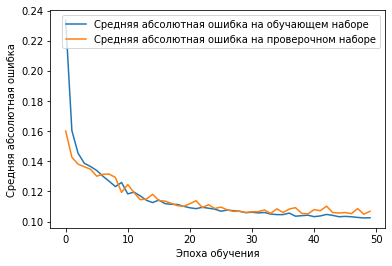

In [ ]:
plt.plot(historyS.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyS.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultS = table(historyS)

In [ ]:
# Заносим результат в таблицу
df_result.loc['На простых цифровых'] = [min(resultS[0]), min(resultS[1]), min(resultS[2]), min(resultS[3])]

In [ ]:
df_result

,loss,mae,val_loss,val_mae
На простых цифровых,0.768525,0.102395,0.10531,0.104845


### 3.6.2 Нейронная сеть на простых текстовых данных

In [ ]:
modelText = Sequential()
modelText.add(BatchNormalization(input_shape=(xTrainBag.shape[1],)))
modelText.add(Dense(128, activation='relu'))
modelText.add(Dense(1000, activation='tanh'))
modelText.add(Dense(100, activation='relu'))
modelText.add(Dense(1, activation='linear'))

modelText.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])

historyText = modelText.fit(xTrainBag, 
                    yTrainScaled, 
                    epochs=50, 
                    batch_size=500,
                    validation_split=0.15, 
                    verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
107/107 - 1s - loss: 1.1658 - mae: 0.2506 - val_loss: 0.3469 - val_mae: 0.1688
Epoch 2/50
107/107 - 0s - loss: 1.1077 - mae: 0.1913 - val_loss: 0.3394 - val_mae: 0.1638
Epoch 3/50
107/107 - 0s - loss: 1.0828 - mae: 0.1724 - val_loss: 0.3325 - val_mae: 0.1637
Epoch 4/50
107/107 - 0s - loss: 1.0646 - mae: 0.1650 - val_loss: 0.3275 - val_mae: 0.1612
Epoch 5/50
107/107 - 0s - loss: 1.0473 - mae: 0.1573 - val_loss: 0.3247 - val_mae: 0.1639
Epoch 6/50
107/107 - 0s - loss: 1.0340 - mae: 0.1530 - val_loss: 0.3219 - val_mae: 0.1635
Epoch 7/50
107/107 - 0s - loss: 1.0207 - mae: 0.1496 - val_loss: 0.3194 - val_mae: 0.1630
Epoch 8/50
107/107 - 0s - loss: 1.0121 - mae: 0.1497 - val_loss: 0.3162 - val_mae: 0.1564
Epoch 9/50
107/107 - 0s - loss: 0.9957 - mae: 0.1418 - val_loss: 0.3138 - val_mae: 0.1565
Epoch 10/50
107/107 - 0s - loss: 0.9847 - mae: 0.1416 - val_loss: 0.3116 - val_mae: 0.1533
Epoch 11/50
107/107 - 0s - loss: 0.9753 - mae: 0.1375 - val_loss: 0.3094 - val_mae: 0.1529
Epoch 12

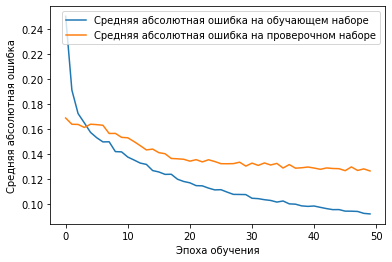

In [ ]:
plt.plot(historyText.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyText.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultText = table(historyText)

In [ ]:
# Заносим результат в таблицу
df_result.loc['На простых текстовых'] = [min(resultText[0]), min(resultText[1]), min(resultText[2]), min(resultText[3])]

In [ ]:
df_result

,loss,mae,val_loss,val_mae
На простых цифровых,0.768525,0.102395,0.105310,0.104845
На простых текстовых,0.486489,0.091765,0.279508,0.126268


### 3.6.3 Составная нейронная сеть числовые и тектовые данные.

In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [ ]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input(xTrainBag.shape[1],)

x1 = Dense(10, activation='relu')(input1)
x2 = Dense(250, activation='relu')(input2)

x = concatenate([x1,x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

modelComplex = Model((input1, input2), x)

#### Шаг обучения 1e-3

In [ ]:
modelComplex.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
historyComplex = modelComplex.fit([xTrainScaled[~valMask], xTrainBag[~valMask]], yTrainScaled[~valMask], epochs=50, 
                    validation_data=([xTrainScaled[valMask], xTrainBag[valMask]], yTrainScaled[valMask]), 
                    verbose= 2)

Epoch 1/50
1566/1566 - 5s - loss: 0.7949 - mae: 0.1665 - val_loss: 1.4742 - val_mae: 0.1455
Epoch 2/50
1566/1566 - 4s - loss: 0.7542 - mae: 0.1241 - val_loss: 1.4442 - val_mae: 0.1245
Epoch 3/50
1566/1566 - 4s - loss: 0.7370 - mae: 0.1101 - val_loss: 1.4263 - val_mae: 0.1143
Epoch 4/50
1566/1566 - 4s - loss: 0.7236 - mae: 0.1014 - val_loss: 1.4076 - val_mae: 0.1095
Epoch 5/50
1566/1566 - 4s - loss: 0.7113 - mae: 0.0954 - val_loss: 1.3862 - val_mae: 0.1069
Epoch 6/50
1566/1566 - 4s - loss: 0.6994 - mae: 0.0909 - val_loss: 1.3734 - val_mae: 0.1010
Epoch 7/50
1566/1566 - 4s - loss: 0.6881 - mae: 0.0867 - val_loss: 1.3564 - val_mae: 0.0995
Epoch 8/50
1566/1566 - 4s - loss: 0.6768 - mae: 0.0838 - val_loss: 1.3416 - val_mae: 0.0950
Epoch 9/50
1566/1566 - 4s - loss: 0.6661 - mae: 0.0800 - val_loss: 1.3233 - val_mae: 0.0998
Epoch 10/50
1566/1566 - 4s - loss: 0.6552 - mae: 0.0783 - val_loss: 1.3096 - val_mae: 0.0921
Epoch 11/50
1566/1566 - 4s - loss: 0.6447 - mae: 0.0757 - val_loss: 1.2930 - va

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultComplex = table(historyComplex)

In [ ]:
# Заносим результат в таблицу
df_result.loc['Составная: числовые и текстовые, шаг обучения 1e-3'] = [min(resultComplex[0]), min(resultComplex[1]), min(resultComplex[2]), min(resultComplex[3])]

In [ ]:
df_result

,loss,mae,val_loss,val_mae
На простых цифровых,0.768525,0.102395,0.105310,0.104845
На простых текстовых,0.486489,0.091765,0.279508,0.126268
"Составная: числовые и текстовые, шаг обучения 1e-3",0.214492,0.040361,0.537540,0.075409


#### Шаг обучения 1e-4

In [ ]:
modelComplex.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
historyComplex = modelComplex.fit([xTrainScaled[~valMask], xTrainBag[~valMask]], yTrainScaled[~valMask], epochs=50, 
                    validation_data=([xTrainScaled[valMask], xTrainBag[valMask]], yTrainScaled[valMask]), 
                    verbose= 2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
1566/1566 - 4s - loss: 0.2065 - mae: 0.0397 - val_loss: 0.5236 - val_mae: 0.0768
Epoch 2/50
1566/1566 - 4s - loss: 0.1959 - mae: 0.0391 - val_loss: 0.5013 - val_mae: 0.0762
Epoch 3/50
1566/1566 - 4s - loss: 0.1843 - mae: 0.0393 - val_loss: 0.4811 - val_mae: 0.0752
Epoch 4/50
1566/1566 - 4s - loss: 0.1739 - mae: 0.0382 - val_loss: 0.4601 - val_mae: 0.0762
Epoch 5/50
1566/1566 - 4s - loss: 0.1632 - mae: 0.0386 - val_loss: 0.4391 - val_mae: 0.0753
Epoch 6/50
1566/1566 - 4s - loss: 0.1534 - mae: 0.0384 - val_loss: 0.4205 - val_mae: 0.0745
Epoch 7/50
1566/1566 - 4s - loss: 0.1435 - mae: 0.0376 - val_loss: 0.4034 - val_mae: 0.0862
Epoch 8/50
1566/1566 - 4s - loss: 0.1330 - mae: 0.0380 - val_loss: 0.3764 - val_mae: 0.0762
Epoch 9/50
1566/1566 - 4s - loss: 0.1232 - mae: 0.0375 - val_loss: 0.3586 - val_mae: 0.0756
Epoch 10/50
1566/1566 - 4s - loss: 0.1145 - mae: 0.0374 - val_loss: 0.3381 - val_mae: 0.0752
Epoch 11/50
1566/1566 - 4s - loss: 0.1049 - mae: 0.0370 - val_loss: 0.3185 - va

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultComplex = table(historyComplex)

In [ ]:
# Заносим результат в таблицу
df_result.loc['Составная: числовые и текстовые, шаг обучения 1e-4'] = [min(resultComplex[0]), min(resultComplex[1]), min(resultComplex[2]), min(resultComplex[3])]

In [ ]:
df_result

,loss,mae,val_loss,val_mae
На простых цифровых,0.768525,0.102395,0.105310,0.104845
На простых текстовых,0.486489,0.091765,0.279508,0.126268
"Составная: числовые и текстовые, шаг обучения 1e-3",0.214492,0.040361,0.537540,0.075409
"Составная: числовые и текстовые, шаг обучения 1e-4",0.005933,0.024817,0.065447,0.067653


### Шаг обучения 1e-5

In [ ]:
print("Меняем шаг обучения на 1е-5")
modelComplex.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])
historyComplex = modelComplex.fit([xTrainScaled[~valMask], xTrainBag[~valMask]], yTrainScaled[~valMask], epochs=50, 
                    validation_data=([xTrainScaled[valMask], xTrainBag[valMask]], yTrainScaled[valMask]), 
                    verbose= 2)

---------------------------------------------
Меняем шаг обучения на 1е-5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
1566/1566 - 4s - loss: 0.0061 - mae: 0.0249 - val_loss: 0.0687 - val_mae: 0.0694
Epoch 2/50
1566/1566 - 4s - loss: 0.0060 - mae: 0.0237 - val_loss: 0.0751 - val_mae: 0.0938
Epoch 3/50
1566/1566 - 4s - loss: 0.0058 - mae: 0.0243 - val_loss: 0.0669 - val_mae: 0.0675
Epoch 4/50
1566/1566 - 4s - loss: 0.0056 - mae: 0.0239 - val_loss: 0.0670 - val_mae: 0.0674
Epoch 5/50
1566/1566 - 4s - loss: 0.0055 - mae: 0.0236 - val_loss: 0.0637 - val_mae: 0.0674
Epoch 6/50
1566/1566 - 4s - loss: 0.0057 - mae: 0.0234 - val_loss: 0.0659 - val_mae: 0.0709
Epoch 7/50
1566/1566 - 4s - loss: 0.0055 - mae: 0.0231 - val_loss: 0.0683 - val_mae: 0.0758
Epoch 8/50
1566/1566 - 4s - loss: 0.0053 - mae: 0.0235 - val_loss: 0.0677 - val_mae: 0.0665
Epoch 9/50
1566/1566 - 4s - loss: 0.0055 - mae: 0.0232 - val_loss: 0.0690 - val_mae: 0.0674
Epoch 10/50
1566/1566 - 4s - loss: 0.0054 - mae: 0.0227 - val_loss: 0.0671 - val_mae: 0.0686
Epoch 11/50
1566/1566 - 4s - loss: 0.0054 - mae: 0.0225 - val_loss: 0.0665 - va

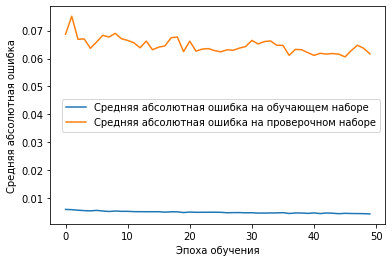

In [ ]:
# График ошибки
plt.plot(historyComplex.history['loss'], label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyComplex.history['val_loss'], label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

**Далее уменьшать шаг обучения не имеет смыслать, так как ошибка не уменьшается и остается на одном месте. **

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultComplex = table(historyComplex)

In [ ]:
# Заносим результат в таблицу
df_result.loc['Составная: числовые и текстовые, шаг обучения 1e-5'] = [min(resultComplex[0]), min(resultComplex[1]), min(resultComplex[2]), min(resultComplex[3])]

# 4. Общая таблица

In [ ]:
df_result

,loss,mae,val_loss,val_mae
На простых цифровых,0.768525,0.102395,0.105310,0.104845
На простых текстовых,0.486489,0.091765,0.279508,0.126268
"Составная: числовые и текстовые, шаг обучения 1e-3",0.214492,0.040361,0.537540,0.075409
"Составная: числовые и текстовые, шаг обучения 1e-4",0.005933,0.024817,0.065447,0.067653
"Составная: числовые и текстовые, шаг обучения 1e-5",0.004452,0.018722,0.060585,0.062054


# 5. Выводы 

В результате проведенной работы было выявлено следующее:

**1.** На простых цифровый данных сеть показала худший результат

**2.**  На текстовых данных (Примечании) нейронная сеть показала резкльтат лучше.


    После этого проводилась работа с составной нейронной сетью (числовые данные + текстовые) с уменьшением шага lr.

**3.** Данный подход показал лучший результат. Что видно из сравнительной таблицы в п.4

**4.** Не смотря на то, что составная нейронная сеть обучается дольше, этот вариант является предпочтительнее. 

**5.** Большую часть времени в данной задаче регрессии (как и в большинства других задач) заняло парсинг базы и сбор тренировочной и тестовой выборок.

**6.** Нормализация данных существенно улучшает результат работы нейронной сети.

**7.** Для более точного сравнения результатов требуется считать среднее значение из 10 обучений какждой нейронной сети. 